# 프로젝트 3: 설비관리 - 예지보전 & 센서 이상탐지

## 프로젝트 배경

당신은 **한국정밀산업(주)** 설비기술팀의 데이터 분석가입니다.  
최근 설비 고장이 연이어 발생하면서 경영진이 **예지보전(Predictive Maintenance)** 시스템 도입을 검토 중입니다.

> *"지난 4월에 EQ-A03 밀링머신이 베어링 고장으로 48시간 정지했고,  
> 5월에는 EQ-C02 CNC선반이 과열로 비상정지했습니다.  
> 센서 데이터를 분석하면 고장을 미리 예측할 수 있을까요?  
> 고장 전에 어떤 징후가 있었는지 분석해 주세요."*

### 분석 목표
1. **센서 데이터 탐색** - 12대 설비의 온도·진동·전류·압력 패턴 파악
2. **이상치 탐지** - 통계적 방법(3-sigma, IQR, 이동평균)으로 이상 신호 탐지
3. **고장 전조 분석** - 고장 발생 전 센서 데이터 변화 패턴 추적
4. **정비 이력 연계** - 정비/고장 이력과 센서 데이터 상관관계 분석
5. **설비 건강도 스코어링** - 설비 상태를 점수화하여 우선순위 도출

### 데이터 설명

| 파일 | 설명 | 주요 컬럼 |
|------|------|----------|
| `p3_equipment.csv` | 설비 마스터 (12대) | equipment_id, cumulative_hours, pm_cycle_days, criticality |
| `p3_sensor_log.csv` | 센서 시계열 (~21,000건, 2시간 주기) | timestamp, temperature_c, vibration_mms, current_a, pressure_bar |
| `p3_maintenance_log.csv` | 정비/고장 이력 (~230건) | maintenance_type(PM/CM/BM/INS), cause, duration_hours, cost_won |
| `p3_alarm_log.csv` | 설비 알람 기록 (~130건) | alarm_type, severity(경고/위험/긴급), acknowledged |

### 정비 유형

| 코드 | 유형 | 설명 |
|------|------|------|
| PM | 예방정비 | 계획된 정기 정비 |
| CM | 고장수리 | 설비 고장 후 수리 |
| BM | 사후보전 | 소규모 사후 조치 |
| INS | 점검 | 일상/주간 점검 |

### 예지보전의 핵심 개념

```
고장 발생 패턴:
  정상 운전 → 초기 징후(미세 변화) → 악화(명확한 이상) → 고장 발생

탐지 방법:
  1. 임계값 기반: 센서값 > 기준치 → 알람
  2. 통계적 방법: 이동평균/표준편차 벗어남 → 이상
  3. 추세 분석: 시간에 따른 변화율 증가 → 열화 진행
```

---

## Part 0: 환경 설정 및 데이터 로드

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

equip = pd.read_csv('../data/project3/p3_equipment.csv', encoding='utf-8-sig')
sensor = pd.read_csv('../data/project3/p3_sensor_log.csv', encoding='utf-8-sig')
maint = pd.read_csv('../data/project3/p3_maintenance_log.csv', encoding='utf-8-sig')
alarm = pd.read_csv('../data/project3/p3_alarm_log.csv', encoding='utf-8-sig')

sensor['timestamp'] = pd.to_datetime(sensor['timestamp'])
maint['date'] = pd.to_datetime(maint['date'])
alarm['timestamp'] = pd.to_datetime(alarm['timestamp'])

print('데이터 로드 완료!')
print(f'설비: {len(equip)}건 | 센서: {len(sensor):,}건 | 정비: {len(maint)}건 | 알람: {len(alarm)}건')

데이터 로드 완료!
설비: 12건 | 센서: 21,750건 | 정비: 230건 | 알람: 132건


---
## Part 1: 데이터 탐색 및 전처리 (15점)

센서 데이터는 2시간 간격으로 수집되며, 센서 오류/통신 장애로 결측치가 포함됩니다.  
시계열 데이터에서의 결측치는 **보간(interpolation)**으로 처리하는 것이 일반적입니다.

### 문제 1-1: 데이터 탐색 (5점)

1. 4개 데이터프레임의 기본 정보(shape, dtypes)를 확인하세요
2. `sensor` 데이터의 결측치 현황을 컬럼별로 확인하세요
3. `sensor` 데이터의 기간(시작~끝), 설비별 건수를 확인하세요
4. `maint` 데이터의 정비 유형별 건수를 확인하세요
5. `equip` 테이블에서 설비별 누적가동시간과 중요도(criticality)를 확인하세요

In [120]:
# 1. 4개 데이터프레임의 기본 정보(shape, dtypes)를 확인하세요
# 5. `equip` 테이블에서 설비별 누적가동시간과 중요도(criticality)를 확인하세요
equip

,equipment_id,equipment_name,line,equipment_type,install_date,cumulative_hours,pm_cycle_days,last_pm_date,criticality
0,EQ-A01,CNC선반-A1,A라인,CNC선반,2018-03-15,12500,90,2024-01-15,A
1,EQ-A02,CNC선반-A2,A라인,CNC선반,2018-06-20,12100,90,2024-02-01,B
2,EQ-A03,밀링머신-A3,A라인,밀링머신,2019-01-10,10800,60,2024-01-20,A
3,EQ-A04,드릴프레스-A4,A라인,드릴프레스,2019-04-05,10200,120,2023-12-10,C
4,EQ-B01,CNC선반-B1,B라인,CNC선반,2021-07-01,5800,90,2024-02-15,B
5,EQ-B02,CNC선반-B2,B라인,CNC선반,2021-09-15,5500,90,2024-02-20,B
6,EQ-B03,밀링머신-B3,B라인,밀링머신,2022-02-10,4200,60,2024-03-01,A
7,EQ-B04,드릴프레스-B4,B라인,드릴프레스,2022-05-20,3900,120,2024-01-25,C
8,EQ-C01,CNC선반-C1,C라인,CNC선반,2020-01-15,8500,90,2024-01-10,B
9,EQ-C02,CNC선반-C2,C라인,CNC선반,2020-04-10,8200,90,2024-02-05,A


In [121]:
equip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   equipment_id      12 non-null     object
 1   equipment_name    12 non-null     object
 2   line              12 non-null     object
 3   equipment_type    12 non-null     object
 4   install_date      12 non-null     object
 5   cumulative_hours  12 non-null     int64 
 6   pm_cycle_days     12 non-null     int64 
 7   last_pm_date      12 non-null     object
 8   criticality       12 non-null     object
dtypes: int64(2), object(7)
memory usage: 992.0+ bytes


In [122]:
# 1. 4개 데이터프레임의 기본 정보(shape, dtypes)를 확인하세요
sensor

,sensor_id,timestamp,equipment_id,temperature_c,vibration_mms,current_a,pressure_bar
0,S-000001,2024-01-01 00:00:00,EQ-A01,40.3,2.19,15.8,4.75
1,S-000002,2024-01-01 00:00:00,EQ-A02,43.6,2.36,13.5,4.83
2,S-000003,2024-01-01 00:00:00,EQ-A03,43.7,3.02,16.0,4.85
3,S-000004,2024-01-01 00:00:00,EQ-A04,41.5,2.04,12.1,5.21
4,S-000005,2024-01-01 00:00:00,EQ-B01,36.7,1.13,11.3,5.42
...,...,...,...,...,...,...,...
21745,S-021746,2024-06-29 22:00:00,EQ-B04,40.7,1.07,10.7,5.50
21746,S-021747,2024-06-29 22:00:00,EQ-C01,43.7,2.04,15.2,5.17
21747,S-021748,2024-06-29 22:00:00,EQ-C02,45.3,1.85,14.7,5.17
21748,S-021749,2024-06-29 22:00:00,EQ-C03,40.2,2.24,15.6,5.19


In [123]:
# 2. `sensor` 데이터의 결측치 현황을 컬럼별로 확인하세요
sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21750 entries, 0 to 21749
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sensor_id      21750 non-null  object        
 1   timestamp      21750 non-null  datetime64[ns]
 2   equipment_id   21750 non-null  object        
 3   temperature_c  21315 non-null  float64       
 4   vibration_mms  21044 non-null  float64       
 5   current_a      21517 non-null  float64       
 6   pressure_bar   21558 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 1.2+ MB


In [124]:
# 3. `sensor` 데이터의 기간(시작~끝), 설비별 건수를 확인하세요
print(sensor['timestamp'].min(), '~', sensor['timestamp'].max())

2024-01-01 00:00:00 ~ 2024-06-29 22:00:00


In [125]:
sensor['equipment_id'].value_counts()

equipment_id
EQ-B01    1829
EQ-A02    1827
EQ-C01    1827
EQ-B04    1826
EQ-C04    1826
EQ-B02    1818
EQ-A04    1816
EQ-B03    1815
EQ-C03    1800
EQ-A01    1797
EQ-C02    1786
EQ-A03    1783
Name: count, dtype: int64

In [126]:
# 1. 4개 데이터프레임의 기본 정보(shape, dtypes)를 확인하세요
maint

,maintenance_id,date,equipment_id,maintenance_type,description,cause,duration_hours,cost_won,parts_replaced,technician_id
0,MT-00001,2024-01-01,EQ-A02,INS,주간점검 - 일상점검,일상점검,1.0,14000,NaN,TECH-08
1,MT-00002,2024-01-01,EQ-B01,INS,주간점검 - 진동측정,진동측정,1.0,24000,NaN,TECH-01
2,MT-00003,2024-01-01,EQ-C01,INS,주간점검 - 온도측정,온도측정,2.0,42000,NaN,TECH-07
3,MT-00004,2024-01-03,EQ-C02,BM,사후보전 - 소모품교체,소모품교체,3.0,105000,베어링,TECH-07
4,MT-00005,2024-01-04,EQ-C03,CM,고장수리 - 모터과열,모터과열,46.0,1237000,NaN,TECH-04
...,...,...,...,...,...,...,...,...,...,...
225,MT-00226,2024-06-24,EQ-C03,INS,주간점검 - 진동측정,진동측정,2.0,37000,NaN,TECH-02
226,MT-00227,2024-06-25,EQ-A01,BM,사후보전 - 윤활,윤활,2.0,144000,베어링,TECH-03
227,MT-00228,2024-06-25,EQ-C02,BM,사후보전 - 볼트조임,볼트조임,2.0,37000,오일,TECH-08
228,MT-00229,2024-06-28,EQ-A03,CM,고장수리 - 냉각계통이상,냉각계통이상,23.0,424000,NaN,TECH-06


In [127]:
# 4. `maint` 데이터의 정비 유형별 건수를 확인하세요
maint['maintenance_type'].value_counts()

maintenance_type
INS    166
BM      30
PM      19
CM      15
Name: count, dtype: int64

In [128]:
# 1. 4개 데이터프레임의 기본 정보(shape, dtypes)를 확인하세요
alarm

,alarm_id,timestamp,equipment_id,alarm_type,alarm_value,threshold,severity,acknowledged,resolved
0,ALM-00001,2024-01-02 06:00:00,EQ-A03,CRITICAL_VIBRATION,9.10,8.0,위험,False,False
1,ALM-00002,2024-01-02 08:00:00,EQ-A02,CRITICAL_VIBRATION,9.38,8.0,위험,True,True
2,ALM-00003,2024-01-04 00:00:00,EQ-B03,HIGH_VIBRATION,6.05,5.0,경고,True,True
3,ALM-00004,2024-01-04 20:00:00,EQ-A02,HIGH_VIBRATION,6.96,5.0,경고,False,True
4,ALM-00005,2024-01-08 18:00:00,EQ-C01,HIGH_TEMP,59.10,55.0,경고,True,True
...,...,...,...,...,...,...,...,...,...
127,ALM-00128,2024-06-20 08:00:00,EQ-C04,CRITICAL_VIBRATION,9.29,8.0,위험,True,True
128,ALM-00129,2024-06-26 10:00:00,EQ-C04,CRITICAL_VIBRATION,9.08,8.0,위험,True,False
129,ALM-00130,2024-06-26 16:00:00,EQ-A03,HIGH_TEMP,63.00,55.0,경고,True,True
130,ALM-00131,2024-06-28 12:00:00,EQ-A01,CRITICAL_VIBRATION,9.25,8.0,위험,False,True


### 문제 1-2: 센서 데이터 결측치 처리 (5점)

시계열 센서 데이터의 결측치는 **설비별 시간순 보간**이 가장 적합합니다.

1. 설비별로 그룹화한 후, 수치형 컬럼의 결측치를 **선형 보간(interpolate)**으로 처리
2. 보간 후에도 남는 결측치(시작/끝 부분)는 **전방/후방 채움(ffill/bfill)**으로 처리
3. 처리 후 결측치가 0인지 확인

In [129]:
# 1. 설비별로 그룹화한 후, 수치형 컬럼의 결측치를 **선형 보간(interpolate)**으로 처리
# 2. 보간 후에도 남는 결측치(시작/끝 부분)는 **전방/후방 채움(ffill/bfill)**으로 처리
# 3. 처리 후 결측치가 0인지 확인
sensor = sensor.sort_values(['equipment_id', 'timestamp']).reset_index(drop=True)
sensor.isna().sum()

sensor_id          0
timestamp          0
equipment_id       0
temperature_c    435
vibration_mms    706
current_a        233
pressure_bar     192
dtype: int64

In [130]:
cols = ['temperature_c', 'vibration_mms', 'current_a', 'pressure_bar']
sensor[cols] = sensor.groupby('equipment_id')[cols].transform(lambda x: x.interpolate(method='linear'))
sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21750 entries, 0 to 21749
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sensor_id      21750 non-null  object        
 1   timestamp      21750 non-null  datetime64[ns]
 2   equipment_id   21750 non-null  object        
 3   temperature_c  21750 non-null  float64       
 4   vibration_mms  21750 non-null  float64       
 5   current_a      21750 non-null  float64       
 6   pressure_bar   21750 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 1.2+ MB


In [131]:
def trans2(x):
    return x.ffill().bfill()

sensor[cols] = sensor.groupby('equipment_id')

ValueError: Columns must be same length as key

### 문제 1-3: 파생 컬럼 및 정비 데이터 결합 (5점)

1. `sensor`에 파생 컬럼 추가:
   - `date` (날짜만)
   - `hour` (시간)
   - `month` (월)
   - `line` (설비ID에서 추출: A라인/B라인/C라인)

2. `maint`에서 `cause` 결측치를 `'원인미상'`으로 대체

3. `equip` 테이블의 `install_date`를 datetime으로 변환하고, **설비 나이(년)**를 계산하세요
   - 기준일: 2024-07-01

In [ ]:
# 1. `sensor`에 파생 컬럼 추가:
#    - `date` (날짜만)
#    - `hour` (시간)
#    - `month` (월)
#    - `line` (설비ID에서 추출: A라인/B라인/C라인)
sensor['date'] = sensor['timestamp'].dt.date
sensor['hour'] = sensor['timestamp'].dt.hour
sensor['month'] = sensor['timestamp'].dt.month
sensor

,sensor_id,timestamp,equipment_id,temperature_c,vibration_mms,current_a,pressure_bar,date,hour,month
0,S-000001,2024-01-01 00:00:00,EQ-A01,40.3,2.19,15.8,4.75,2024-01-01,0,1
1,S-000012,2024-01-01 02:00:00,EQ-A01,44.3,2.17,14.8,4.90,2024-01-01,2,1
2,S-000024,2024-01-01 04:00:00,EQ-A01,43.0,2.62,13.9,5.17,2024-01-01,4,1
3,S-000036,2024-01-01 06:00:00,EQ-A01,43.4,2.83,14.5,5.45,2024-01-01,6,1
4,S-000059,2024-01-01 10:00:00,EQ-A01,40.7,2.20,15.6,5.33,2024-01-01,10,1
...,...,...,...,...,...,...,...,...,...,...
21745,S-021703,2024-06-29 14:00:00,EQ-C04,38.9,1.53,11.2,5.32,2024-06-29,14,6
21746,S-021714,2024-06-29 16:00:00,EQ-C04,41.3,1.86,9.5,5.33,2024-06-29,16,6
21747,S-021726,2024-06-29 18:00:00,EQ-C04,39.1,2.33,12.8,5.15,2024-06-29,18,6
21748,S-021738,2024-06-29 20:00:00,EQ-C04,36.9,2.03,10.8,5.34,2024-06-29,20,6


In [ ]:
def get_line(x):
    if 'A' in x:
        return 'A라인'
    elif 'B' in x:
        return 'B라인'
    elif 'C' in x:
        return 'C라인'

sensor['line'] = sensor['equipment_id'].apply(get_line)
sensor

,sensor_id,timestamp,equipment_id,temperature_c,vibration_mms,current_a,pressure_bar,date,hour,month,line
0,S-000001,2024-01-01 00:00:00,EQ-A01,40.3,2.19,15.8,4.75,2024-01-01,0,1,A라인
1,S-000012,2024-01-01 02:00:00,EQ-A01,44.3,2.17,14.8,4.90,2024-01-01,2,1,A라인
2,S-000024,2024-01-01 04:00:00,EQ-A01,43.0,2.62,13.9,5.17,2024-01-01,4,1,A라인
3,S-000036,2024-01-01 06:00:00,EQ-A01,43.4,2.83,14.5,5.45,2024-01-01,6,1,A라인
4,S-000059,2024-01-01 10:00:00,EQ-A01,40.7,2.20,15.6,5.33,2024-01-01,10,1,A라인
...,...,...,...,...,...,...,...,...,...,...,...
21745,S-021703,2024-06-29 14:00:00,EQ-C04,38.9,1.53,11.2,5.32,2024-06-29,14,6,C라인
21746,S-021714,2024-06-29 16:00:00,EQ-C04,41.3,1.86,9.5,5.33,2024-06-29,16,6,C라인
21747,S-021726,2024-06-29 18:00:00,EQ-C04,39.1,2.33,12.8,5.15,2024-06-29,18,6,C라인
21748,S-021738,2024-06-29 20:00:00,EQ-C04,36.9,2.03,10.8,5.34,2024-06-29,20,6,C라인


In [ ]:
# 2. `maint`에서 `cause` 결측치를 `'원인미상'`으로 대체
maint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   maintenance_id    230 non-null    object        
 1   date              230 non-null    datetime64[ns]
 2   equipment_id      230 non-null    object        
 3   maintenance_type  230 non-null    object        
 4   description       230 non-null    object        
 5   cause             230 non-null    object        
 6   duration_hours    229 non-null    float64       
 7   cost_won          230 non-null    int64         
 8   parts_replaced    56 non-null     object        
 9   technician_id     230 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 18.1+ KB


In [ ]:
maint['cause'] = maint['cause'].fillna('원인미상')
maint.info()

In [ ]:
# 3. `equip` 테이블의 `install_date`를 datetime으로 변환하고, **설비 나이(년)**를 계산하세요
#    - 기준일: 2024-07-01
equip['install_date'] = pd.to_datetime(equip['install_date'])
equip['설비 나이(년)'] = ((pd.Timestamp('2024-07-01') - equip['install_date']).dt.days/365).round(1)
equip

,equipment_id,equipment_name,line,equipment_type,install_date,cumulative_hours,pm_cycle_days,last_pm_date,criticality,설비 나이(년)
0,EQ-A01,CNC선반-A1,A라인,CNC선반,2018-03-15,12500,90,2024-01-15,A,6.3
1,EQ-A02,CNC선반-A2,A라인,CNC선반,2018-06-20,12100,90,2024-02-01,B,6.0
2,EQ-A03,밀링머신-A3,A라인,밀링머신,2019-01-10,10800,60,2024-01-20,A,5.5
3,EQ-A04,드릴프레스-A4,A라인,드릴프레스,2019-04-05,10200,120,2023-12-10,C,5.2
4,EQ-B01,CNC선반-B1,B라인,CNC선반,2021-07-01,5800,90,2024-02-15,B,3.0
5,EQ-B02,CNC선반-B2,B라인,CNC선반,2021-09-15,5500,90,2024-02-20,B,2.8
6,EQ-B03,밀링머신-B3,B라인,밀링머신,2022-02-10,4200,60,2024-03-01,A,2.4
7,EQ-B04,드릴프레스-B4,B라인,드릴프레스,2022-05-20,3900,120,2024-01-25,C,2.1
8,EQ-C01,CNC선반-C1,C라인,CNC선반,2020-01-15,8500,90,2024-01-10,B,4.5
9,EQ-C02,CNC선반-C2,C라인,CNC선반,2020-04-10,8200,90,2024-02-05,A,4.2


---
## Part 2: 센서 데이터 분석 & 이상탐지 (30점)

예지보전의 핵심은 **정상 패턴을 이해하고, 이상을 탐지하는 것**입니다.  
먼저 설비별 센서 데이터의 정상 범위를 파악하고,  
여러 통계적 방법으로 이상 신호를 탐지합니다.

### 문제 2-1: 설비별 센서 기본 통계 (5점)

1. 설비별 4개 센서(온도, 진동, 전류, 압력)의 평균·표준편차·최소·최대를 집계하세요
2. **설비별 평균 온도**를 수평 막대 차트로 시각화 (라인별 색상 구분)
3. **설비별 평균 진동**도 같은 방식으로 시각화
4. 어떤 설비가 센서값이 가장 높은가? (온도, 진동 각각)

In [ ]:
# 1. 설비별 4개 센서(온도, 진동, 전류, 압력)의 평균·표준편차·최소·최대를 집계하세요
cols = ['temperature_c', 'vibration_mms', 'current_a', 'pressure_bar']
sensor_stats = sensor.groupby('equipment_id')[cols].agg(['mean', 'std', 'min', 'max'])
sensor_stats

temperature_c                       vibration_mms            \
                      mean       std   min   max          mean       std   
equipment_id                                                               
EQ-A01           43.490150  2.220436  36.9  61.9      2.573659  0.532509   
EQ-A02           42.583415  2.161427  35.7  62.2      2.407904  0.504642   
EQ-A03           45.494139  2.396841  38.8  66.8      3.144274  0.609298   
EQ-A04           41.693365  2.358822  35.7  64.2      1.919813  0.516785   
EQ-B01           37.277283  2.186085  30.8  54.5      1.169161  0.361971   
EQ-B02           38.439191  2.347167  32.8  57.3      1.314706  0.344503   
EQ-B03           39.480716  2.229717  32.9  61.0      1.515667  0.437205   
EQ-B04           37.397755  2.069789  31.1  54.5      1.142848  0.575367   
EQ-C01           40.671593  2.299828  35.0  62.0      1.866907  0.539387   
EQ-C02           41.548068  2.553043  35.9  63.0      2.031685  0.490799   
EQ-C03           40.587972  2.357205  34.5  58.9      1.770286  0.433346   
EQ-C04           39.489485  2.057740  33.6  56.9      1.580605  0.535282   

                           current_a                       pressure_bar  \
               min    max       mean       std   min   max         mean   
equipment_id                                                              
EQ-A01        1.53  10.49  15.122871  1.197236  11.5  24.0     4.997922   
EQ-A02        1.39  10.28  14.503120  0.991454  11.1  17.7     4.996793   
EQ-A03        1.91  10.66  16.024958  1.002241  12.9  18.8     4.800188   
EQ-A04        0.73   9.66  12.003827  1.010797   8.0  15.5     5.197183   
EQ-B01        0.10   5.78  12.958201  1.001598  10.0  16.8     5.506192   
EQ-B02        0.14   6.88  13.510176  1.019537  10.6  17.2     5.394340   
EQ-B03        0.41   8.42  14.013664  0.997820  11.3  17.5     5.293893   
EQ-B04        0.18   8.88  11.017497  0.999168   7.9  14.6     5.504165   
EQ-C01        0.62   9.39  14.012288  0.996253  10.7  17.3     5.096924   
EQ-C02        0.96   8.77  14.487402  0.966136  11.6  17.5     4.984947   
EQ-C03        0.45   9.54  14.028056  0.992800  10.7  17.8     5.204689   
EQ-C04        0.60   9.29  11.983817  1.001344   8.6  15.2     5.298100   

                                    
                   std   min   max  
equipment_id                        
EQ-A01        0.197943  4.27  5.65  
EQ-A02        0.199427  4.19  5.69  
EQ-A03        0.206069  4.12  5.48  
EQ-A04        0.197567  4.57  5.82  
EQ-B01        0.202980  4.75  6.19  
EQ-B02        0.196680  4.70  6.04  
EQ-B03        0.202121  4.52  5.89  
EQ-B04        0.195073  4.77  6.21  
EQ-C01        0.196273  4.36  5.81  
EQ-C02        0.198208  4.41  5.58  
EQ-C03        0.200189  4.56  6.15  
EQ-C04        0.201181  4.66  5.98

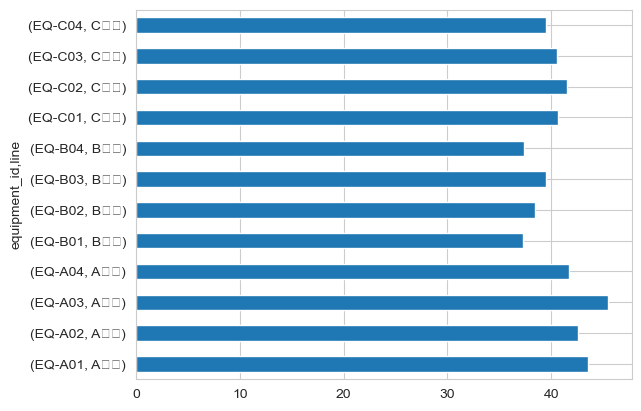

In [ ]:
# 2. **설비별 평균 온도**를 수평 막대 차트로 시각화 (라인별 색상 구분)
sensor.groupby(['equipment_id', 'line'])['temperature_c'].mean().plot(kind='barh')
plt.show()

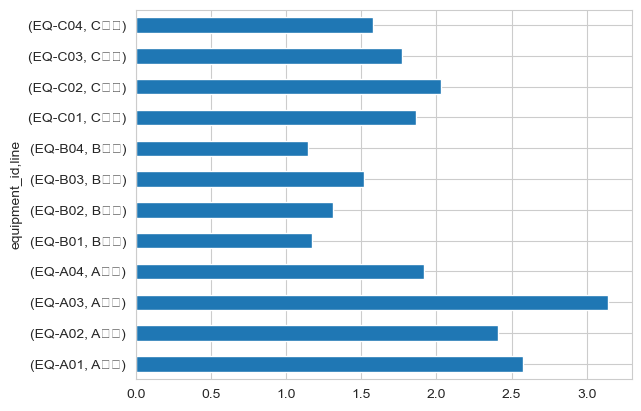

In [ ]:
# 3. **설비별 평균 진동**도 같은 방식으로 시각화
sensor.groupby(['equipment_id', 'line'])['vibration_mms'].mean().plot(kind='barh')
plt.show()

In [ ]:
# 4. 어떤 설비가 센서값이 가장 높은가? (온도, 진동 각각)
print(f"온도: {sensor.groupby('equipment_id')['temperature_c'].mean().idxmax()}")
print(f"진동: {sensor.groupby('equipment_id')['vibration_mms'].mean().idxmax()}")

온도: EQ-A03
진동: EQ-A03


### 문제 2-2: 센서 시계열 시각화 (5점)

**고장이 발생한 3대 설비(EQ-A03, EQ-C02, EQ-A01)**의 센서 데이터를 시계열로 시각화하세요.

1. 3개 설비 × 2개 센서(온도, 진동) = **3행 2열 서브플롯** (Figure 18×12)
2. 각 차트에 일별 이동평균(7일)도 함께 표시 (빨간 실선)
3. 고장 발생일을 세로 점선으로 표시:
   - EQ-A03: 2024-04-15 (베어링 고장)
   - EQ-C02: 2024-05-20 (과열 정지)
   - EQ-A01: 2024-03-10 (전류 이상)
4. 고장 전 10일간 데이터에 배경색(빨간 음영)을 표시하세요

> **현업 포인트**: 시계열 차트에서 "고장 전에 서서히 올라가는 패턴"을 찾아보세요.

3


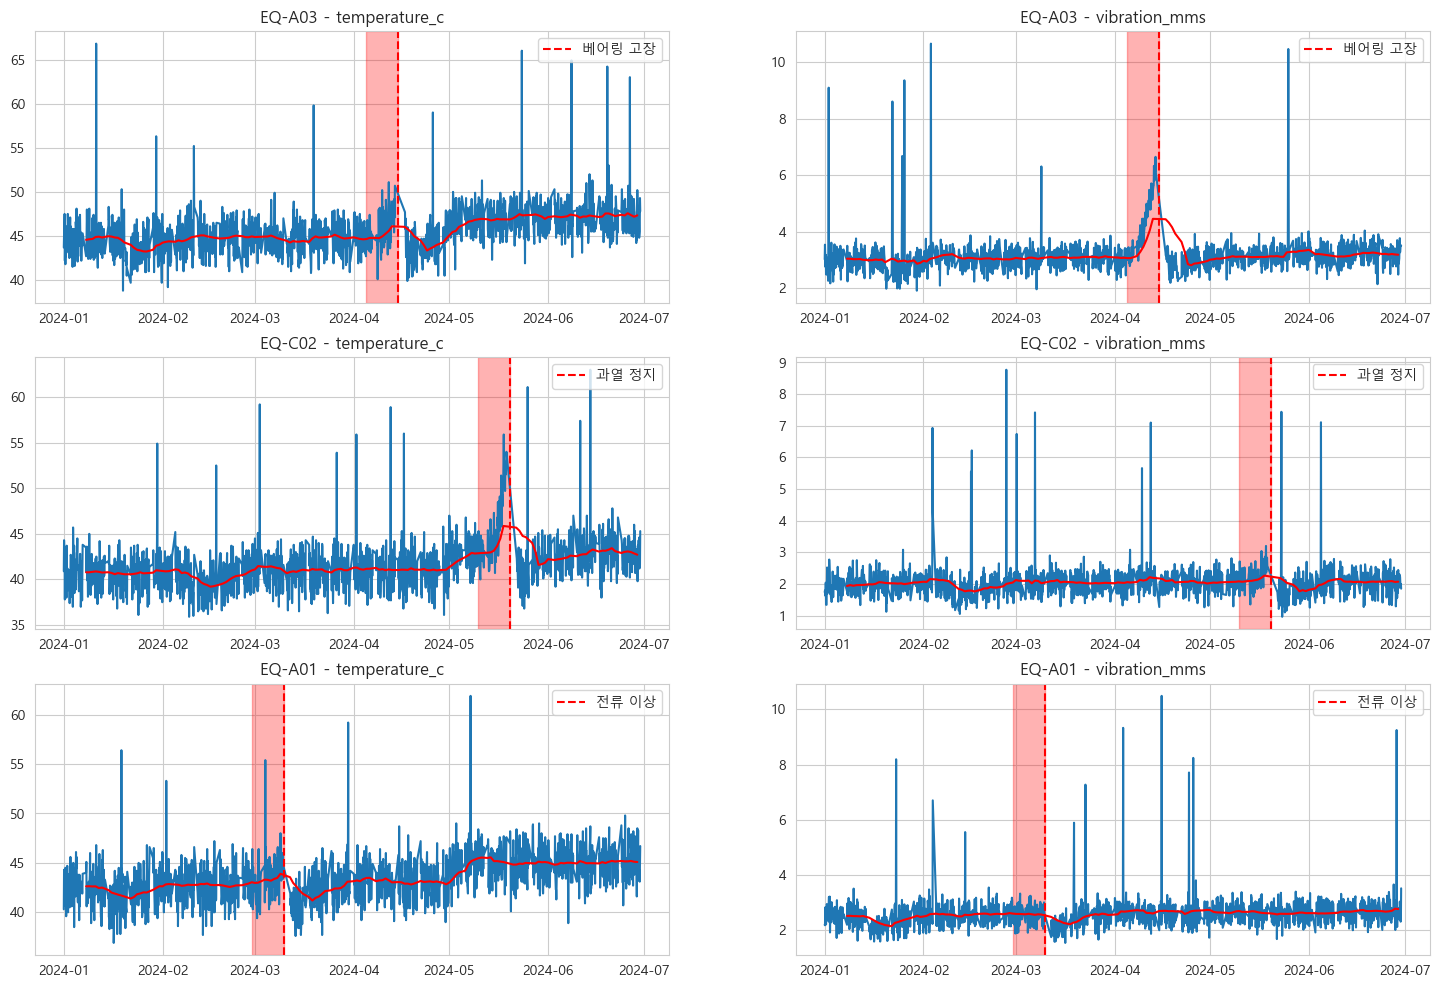

In [233]:
# 1. 3개 설비 × 2개 센서(온도, 진동) = **3행 2열 서브플롯** (Figure 18×12)
equip_list = ['EQ-A03', 'EQ-C02', 'EQ-A01']
defect_date = [('2024-04-15', '베어링 고장'), ('2024-05-20', '과열 정지'), ('2024-03-10', '전류 이상')]
sensor_list = ['temperature_c', 'vibration_mms']

fig, axs = plt.subplots(3, 2, figsize=(18, 12))
print(len(axs))
for row in range(3):
    for col in range(2):
        data = sensor.loc[sensor['equipment_id'] == equip_list[row], ['timestamp', sensor_list[col]]].set_index('timestamp').sort_index()
        axs[row][col].plot(data)
        # 2. 각 차트에 일별 이동평균(7일)도 함께 표시 (빨간 실선)
        data_7ma = sensor[sensor['equipment_id'] == equip_list[row]]\
                 .groupby(sensor['timestamp'].dt.date)[sensor_list[col]].mean().rolling(window=7).mean()
        axs[row][col].plot(data_7ma, color='red')
        # 3. 고장 발생일을 세로 점선으로 표시:
        #    - EQ-A03: 2024-04-15 (베어링 고장)
        #    - EQ-C02: 2024-05-20 (과열 정지)
        #    - EQ-A01: 2024-03-10 (전류 이상)
        axs[row][col].axvline(pd.to_datetime(defect_date[row][0]), color='red', linestyle='--', label=defect_date[row][1])
        # 4. 고장 전 10일간 데이터에 배경색(빨간 음영)을 표시하세요
        axs[row][col].axvspan(pd.to_datetime(defect_date[row][0]) - pd.Timedelta(days=10),
                              pd.to_datetime(defect_date[row][0]), color='red', alpha=0.3)
        
        axs[row][col].set_title(f"{equip_list[row]} - {sensor_list[col]}")
        axs[row][col].legend(loc='upper right')

plt.show()

### 문제 2-3: 3-Sigma 이상탐지 (10점)

가장 기본적인 이상탐지 방법입니다.  
평균 ± 3σ를 벗어나는 점을 이상으로 판정합니다.

1. **설비별**로 각 센서의 평균(μ)과 표준편차(σ)를 계산
2. `|x - μ| > 3σ`인 점을 이상치로 판정하여 `is_anomaly_temp`, `is_anomaly_vib` 컬럼 추가
3. 설비별 이상치 건수를 집계하세요
4. **EQ-A03의 진동 데이터**를 시계열로 그리고, 이상치를 빨간 점으로 표시하세요
   - μ ± 3σ 범위를 회색 음영으로 표시 (`axhspan`)
5. 이 방법의 한계점은 무엇인가? (고장 전 서서히 증가하는 패턴을 탐지할 수 있는가?)

In [235]:
# 1. **설비별**로 각 센서의 평균(μ)과 표준편차(σ)를 계산
cols = ['temperature_c', 'vibration_mms', 'current_a', 'pressure_bar']
mean_labels = ['temp_mean', 'vib_mean', 'curr_mean', 'press_mean']
std_labels = ['temp_std', 'vib_std', 'curr_std', 'press_std']
sensor[mean_labels] = sensor.groupby('equipment_id')[cols].transform('mean')
sensor[std_labels] = sensor.groupby('equipment_id')[cols].transform('std')
sensor

,sensor_id,timestamp,equipment_id,temperature_c,vibration_mms,current_a,pressure_bar,temp_mean,vib_mean,curr_mean,press_mean,temp_std,vib_std,curr_std,press_std,is_anomaly_temp,is_anomaly_vib
0,S-000001,2024-01-01 00:00:00,EQ-A01,40.3,2.19,15.8,4.75,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
1,S-000012,2024-01-01 02:00:00,EQ-A01,44.3,2.17,14.8,4.90,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
2,S-000024,2024-01-01 04:00:00,EQ-A01,43.0,2.62,13.9,5.17,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
3,S-000036,2024-01-01 06:00:00,EQ-A01,43.4,2.83,14.5,5.45,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
4,S-000059,2024-01-01 10:00:00,EQ-A01,40.7,2.20,15.6,5.33,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21745,S-021703,2024-06-29 14:00:00,EQ-C04,38.9,1.53,11.2,5.32,39.489485,1.580605,11.983817,5.298100,2.057740,0.535282,1.001344,0.201181,False,False
21746,S-021714,2024-06-29 16:00:00,EQ-C04,41.3,1.86,9.5,5.33,39.489485,1.580605,11.983817,5.298100,2.057740,0.535282,1.001344,0.201181,False,False
21747,S-021726,2024-06-29 18:00:00,EQ-C04,39.1,2.33,12.8,5.15,39.489485,1.580605,11.983817,5.298100,2.057740,0.535282,1.001344,0.201181,False,False
21748,S-021738,2024-06-29 20:00:00,EQ-C04,36.9,2.03,10.8,5.34,39.489485,1.580605,11.983817,5.298100,2.057740,0.535282,1.001344,0.201181,False,False


In [236]:
# 2. `|x - μ| > 3σ`인 점을 이상치로 판정하여 `is_anomaly_temp`, `is_anomaly_vib` 컬럼 추가
sensor['is_anomaly_temp'] = (sensor['temperature_c'] - sensor['temp_mean']).abs() > sensor['temp_std']*3
sensor['is_anomaly_vib'] = (sensor['vibration_mms'] - sensor['vib_mean']).abs() > sensor['vib_std']*3
sensor

,sensor_id,timestamp,equipment_id,temperature_c,vibration_mms,current_a,pressure_bar,temp_mean,vib_mean,curr_mean,press_mean,temp_std,vib_std,curr_std,press_std,is_anomaly_temp,is_anomaly_vib
0,S-000001,2024-01-01 00:00:00,EQ-A01,40.3,2.19,15.8,4.75,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
1,S-000012,2024-01-01 02:00:00,EQ-A01,44.3,2.17,14.8,4.90,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
2,S-000024,2024-01-01 04:00:00,EQ-A01,43.0,2.62,13.9,5.17,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
3,S-000036,2024-01-01 06:00:00,EQ-A01,43.4,2.83,14.5,5.45,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
4,S-000059,2024-01-01 10:00:00,EQ-A01,40.7,2.20,15.6,5.33,43.490150,2.573659,15.122871,4.997922,2.220436,0.532509,1.197236,0.197943,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21745,S-021703,2024-06-29 14:00:00,EQ-C04,38.9,1.53,11.2,5.32,39.489485,1.580605,11.983817,5.298100,2.057740,0.535282,1.001344,0.201181,False,False
21746,S-021714,2024-06-29 16:00:00,EQ-C04,41.3,1.86,9.5,5.33,39.489485,1.580605,11.983817,5.298100,2.057740,0.535282,1.001344,0.201181,False,False
21747,S-021726,2024-06-29 18:00:00,EQ-C04,39.1,2.33,12.8,5.15,39.489485,1.580605,11.983817,5.298100,2.057740,0.535282,1.001344,0.201181,False,False
21748,S-021738,2024-06-29 20:00:00,EQ-C04,36.9,2.03,10.8,5.34,39.489485,1.580605,11.983817,5.298100,2.057740,0.535282,1.001344,0.201181,False,False


In [237]:
# 3. 설비별 이상치 건수를 집계하세요
sensor.groupby('equipment_id')['is_anomaly_temp'].sum() + sensor.groupby('equipment_id')['is_anomaly_vib'].sum()

equipment_id
EQ-A01    16
EQ-A02    19
EQ-A03    42
EQ-A04    24
EQ-B01    14
EQ-B02    17
EQ-B03    18
EQ-B04    21
EQ-C01    18
EQ-C02    36
EQ-C03    24
EQ-C04    19
dtype: int64

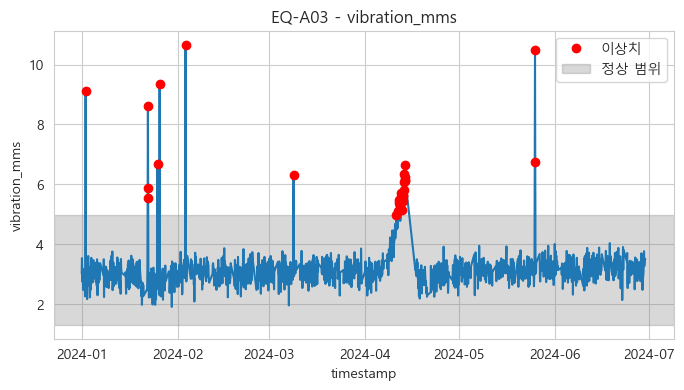

In [357]:
# 4. **EQ-A03의 진동 데이터**를 시계열로 그리고, 이상치를 빨간 점으로 표시하세요
#    - μ ± 3σ 범위를 회색 음영으로 표시 (`axhspan`)
data = sensor.loc[sensor['equipment_id'] == 'EQ-A03', ['timestamp', 'vibration_mms', 'is_anomaly_vib']].set_index('timestamp').sort_index()

plt.figure(figsize=(8, 4))
plt.plot(data['vibration_mms'])
plt.plot(data[data['is_anomaly_vib']].index, data.loc[data['is_anomaly_vib'], 'vibration_mms'], 'o', color='red', label='이상치')
plt.axhspan((data.mean() - 3*data.std()).iloc[0], (data.mean() + 3*data.std()).iloc[0], color='gray', alpha=0.3, label='정상 범위')

plt.title('EQ-A03 - vibration_mms')
plt.xlabel('timestamp')
plt.ylabel('vibration_mms')
plt.legend()

plt.show()

In [ ]:
# 5. 이 방법의 한계점은 무엇인가? (고장 전 서서히 증가하는 패턴을 탐지할 수 있는가?)
# 진동 데이터가 증가하는 시점을 정확히 파악할 수 없다

### 문제 2-4: 이동평균 기반 이상탐지 (10점)

3-Sigma는 전체 기간 평균 기준이라 **점진적 변화**를 놓칩니다.  
**이동평균 기반 탐지**는 최근 데이터 기준으로 이상을 판단합니다.

1. EQ-A03의 진동 데이터에 대해:
   - **24시간 이동평균** (rolling, window=12, 2시간 간격이므로)
   - **24시간 이동표준편차**
   - 동적 상한: 이동평균 + 2 × 이동표준편차
   - 동적 하한: 이동평균 - 2 × 이동표준편차

2. 실제 값이 동적 상/하한을 벗어나는 점을 이상으로 판정

3. 시계열 차트로 시각화:
   - 실제값 (파란 선)
   - 이동평균 (녹색 선)
   - 동적 상/하한 (회색 음영)
   - 이상점 (빨간 점)
   - 고장일 세로선
   - Figure 크기: (16, 6)

4. **7일 이동평균**으로도 같은 분석을 수행하고, 24시간 vs 7일 중 어느 것이  
   고장 전조를 더 잘 탐지하는지 비교하세요

In [358]:
# 1. EQ-A03의 진동 데이터에 대해:
#    - **24시간 이동평균** (rolling, window=12, 2시간 간격이므로)
#    - **24시간 이동표준편차**
#    - 동적 상한: 이동평균 + 2 × 이동표준편차
#    - 동적 하한: 이동평균 - 2 × 이동표준편차
data_12ma = pd.DataFrame(data={'vibration_mms':data['vibration_mms'], 'mean':data['vibration_mms'].rolling(window=12).mean()})
data_12ma['std'] = data['vibration_mms'].rolling(window=12).std()

data_12ma['moving_lb'] = data_12ma['mean'] - 2*data_12ma['std']
data_12ma['moving_ub'] = data_12ma['mean'] + 2*data_12ma['std']
data_12ma

,vibration_mms,mean,std,moving_lb,moving_ub
timestamp,,,,,
2024-01-01 00:00:00,3.02,NaN,NaN,NaN,NaN
2024-01-01 02:00:00,3.54,NaN,NaN,NaN,NaN
2024-01-01 04:00:00,3.17,NaN,NaN,NaN,NaN
2024-01-01 06:00:00,2.75,NaN,NaN,NaN,NaN
2024-01-01 08:00:00,3.18,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-06-29 12:00:00,3.77,3.260833,0.362754,2.535326,3.986340
2024-06-29 14:00:00,3.27,3.269167,0.361624,2.545919,3.992415
2024-06-29 18:00:00,3.52,3.290000,0.368806,2.552387,4.027613


In [359]:
# 2. 실제 값이 동적 상/하한을 벗어나는 점을 이상으로 판정
data_12ma['is_outlier_ma'] = (data_12ma['vibration_mms'] < data_12ma['moving_lb']) | (data_12ma['vibration_mms'] > data_12ma['moving_ub'])
data_12ma['is_outlier_ma'].sum()

np.int64(64)

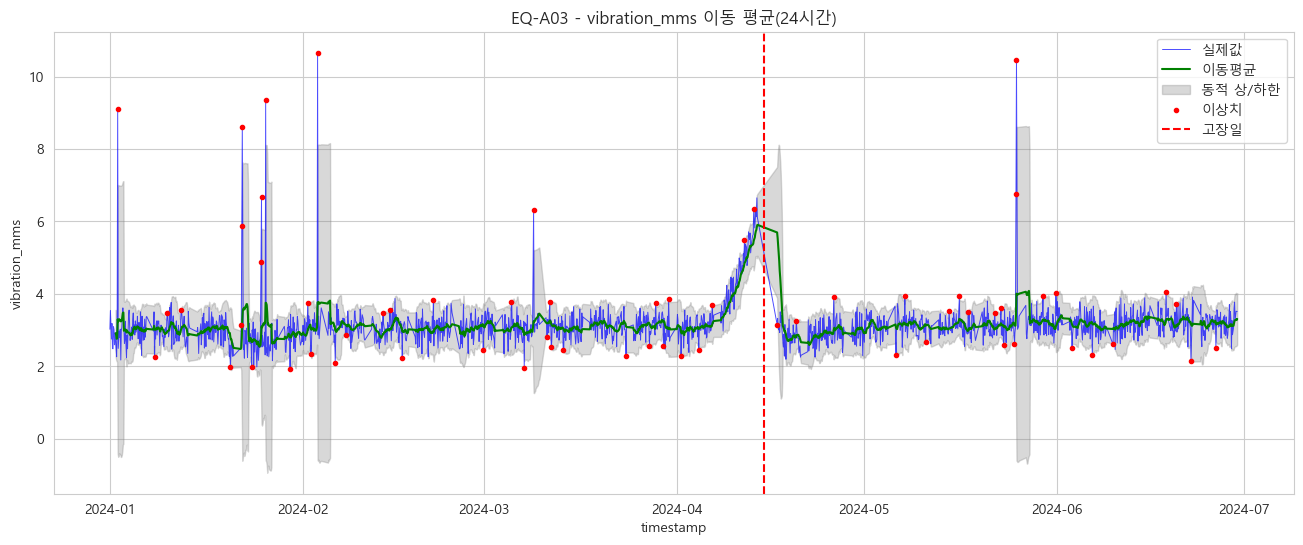

In [375]:
# 3. 시계열 차트로 시각화:
#    - Figure 크기: (16, 6)
plt.figure(figsize=(16, 6))
#    - 실제값 (파란 선)
plt.plot(data_12ma['vibration_mms'], label='실제값', color='blue', linewidth=0.7, alpha=0.7)
#    - 이동평균 (녹색 선)
plt.plot(data_12ma['mean'], label='이동평균', color='green')
#    - 동적 상/하한 (회색 음영)
plt.fill_between(data_12ma.index, data_12ma['moving_lb'], data_12ma['moving_ub'],
                 label='동적 상/하한', color='gray', alpha=0.3)
#    - 이상점 (빨간 점)
plt.plot(data_12ma[data_12ma['is_outlier_ma']].index, data_12ma[data_12ma['is_outlier_ma']]['vibration_mms'], 'o',
         label='이상치', color='red', markersize=3)
#    - 고장일 세로선
plt.axvline(pd.Timestamp('2024-04-15'), label='고장일', color='red', linestyle='--')

plt.title('EQ-A03 - vibration_mms 이동 평균(24시간)')
plt.xlabel('timestamp')
plt.ylabel('vibration_mms')
plt.legend()

plt.show()

In [371]:
# 4. **7일 이동평균**으로도 같은 분석을 수행하고, 24시간 vs 7일 중 어느 것이  
#    고장 전조를 더 잘 탐지하는지 비교하세요
data_84ma = pd.DataFrame(data={'vibration_mms':data['vibration_mms'], 'mean':data['vibration_mms'].rolling(window=84).mean()})
data_84ma['std'] = data['vibration_mms'].rolling(window=84).std()

data_84ma['moving_lb'] = data_84ma['mean'] - 2*data_84ma['std']
data_84ma['moving_ub'] = data_84ma['mean'] + 2*data_84ma['std']
data_84ma

,vibration_mms,mean,std,moving_lb,moving_ub
timestamp,,,,,
2024-01-01 00:00:00,3.02,NaN,NaN,NaN,NaN
2024-01-01 02:00:00,3.54,NaN,NaN,NaN,NaN
2024-01-01 04:00:00,3.17,NaN,NaN,NaN,NaN
2024-01-01 06:00:00,2.75,NaN,NaN,NaN,NaN
2024-01-01 08:00:00,3.18,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-06-29 12:00:00,3.77,3.175595,0.326215,2.523166,3.828024
2024-06-29 14:00:00,3.27,3.180476,0.324498,2.531480,3.829473
2024-06-29 18:00:00,3.52,3.186786,0.325900,2.534986,3.838585


In [372]:
data_84ma['is_outlier_ma'] = (data_84ma['vibration_mms'] < data_84ma['moving_lb']) | (data_84ma['vibration_mms'] > data_84ma['moving_ub'])
data_84ma['is_outlier_ma'].sum()

np.int64(92)

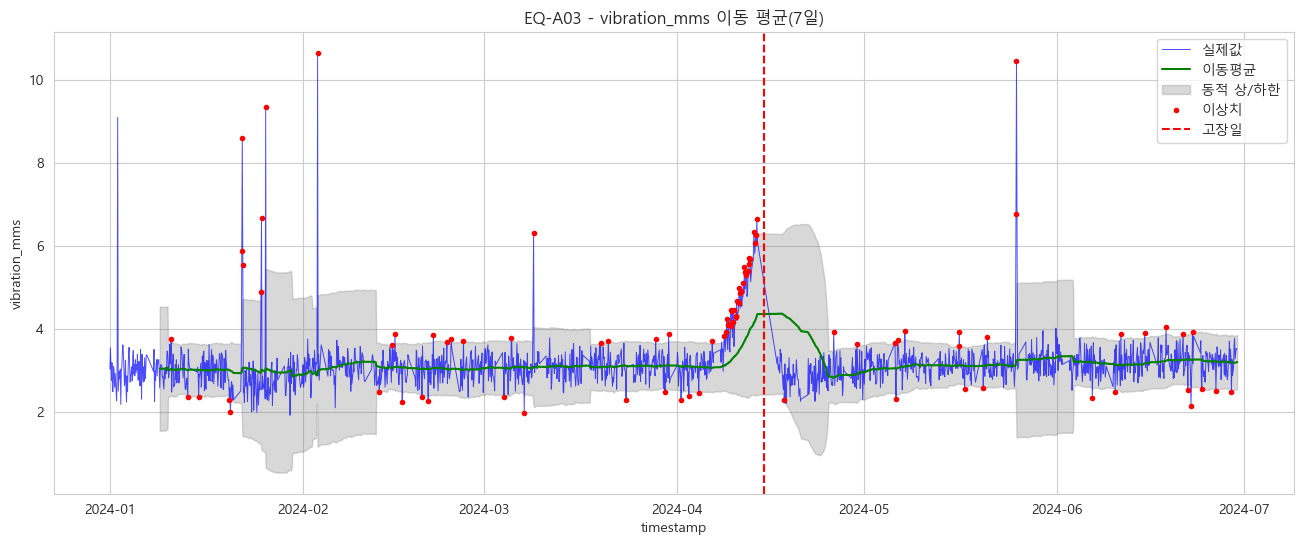

In [376]:
# 3. 시계열 차트로 시각화:
#    - Figure 크기: (16, 6)
plt.figure(figsize=(16, 6))
#    - 실제값 (파란 선)
plt.plot(data_84ma['vibration_mms'], label='실제값', color='blue', linewidth=0.7, alpha=0.7)
#    - 이동평균 (녹색 선)
plt.plot(data_84ma['mean'], label='이동평균', color='green')
#    - 동적 상/하한 (회색 음영)
plt.fill_between(data_84ma.index, data_84ma['moving_lb'], data_84ma['moving_ub'],
                 label='동적 상/하한', color='gray', alpha=0.3)
#    - 이상점 (빨간 점)
plt.plot(data_84ma[data_84ma['is_outlier_ma']].index, data_84ma[data_84ma['is_outlier_ma']]['vibration_mms'], 'o',
         label='이상치', color='red', markersize=3)
#    - 고장일 세로선
plt.axvline(pd.Timestamp('2024-04-15'), label='고장일', color='red', linestyle='--')

plt.title('EQ-A03 - vibration_mms 이동 평균(7일)')
plt.xlabel('timestamp')
plt.ylabel('vibration_mms')
plt.legend()

plt.show()

---
## Part 3: 고장 전조 패턴 분석 (20점)

이상탐지를 넘어, **고장 발생 전에 어떤 패턴이 나타나는지** 구체적으로 분석합니다.  
이 패턴을 알면 향후 고장을 예측할 수 있습니다.

> **현업 포인트**: 고장 전 10일 → 7일 → 3일 → 1일 시점의 센서값 변화를 추적하면  
> "몇 일 전부터 이상 징후가 나타나는지" 파악할 수 있습니다.

### 문제 3-1: 고장 전 센서 변화율 분석 (10점)

3건의 고장(EQ-A03 4/15, EQ-C02 5/20, EQ-A01 3/10)에 대해:

1. 고장 전 14일간의 **일별 평균 센서값**을 추출하세요
2. 정상 기간(고장 30일 전 ~ 15일 전) 대비 **변화율(%)**을 계산하세요
   - 변화율 = (고장전 값 - 정상기간 평균) / 정상기간 평균 × 100
3. 3건의 고장 각각에 대해 **고장 D-14 ~ D-0의 센서 변화율**을 라인 차트로 시각화
   - 1×3 서브플롯 (EQ-A03 진동, EQ-C02 온도, EQ-A01 전류)
   - x축: D-14, D-13, ..., D-1, D-0
   - y축: 변화율 (%)
4. 각 고장에서 **가장 먼저 10% 이상 변화**가 나타나는 시점(D-?)을 확인하세요

In [493]:
# 1. 고장 전 14일간의 **일별 평균 센서값**을 추출하세요
equip_list = ['EQ-A03', 'EQ-C02', 'EQ-A01']
defect_date = ['2024-04-15', '2024-05-20', '2024-03-10']

# EQ-A03
eq_a03_fail_14 = sensor[sensor['equipment_id'] == 'EQ-A03'].groupby(sensor['timestamp'].dt.date)[cols].mean().round(2)
eq_a03_fail_14 = eq_a03_fail_14.loc[pd.to_datetime('2024-04-15').date() - pd.Timedelta(days=14):pd.to_datetime('2024-04-15').date()]

# EQ-C02
eq_c02_fail_14 = sensor[sensor['equipment_id'] == 'EQ-C02'].groupby(sensor['timestamp'].dt.date)[cols].mean().round(2)
eq_c02_fail_14 = eq_c02_fail_14.loc[pd.to_datetime('2024-05-20').date() - pd.Timedelta(days=14):pd.to_datetime('2024-05-20').date()]

# EQ-A01
eq_a01_fail_14 = sensor[sensor['equipment_id'] == 'EQ-A01'].groupby(sensor['timestamp'].dt.date)[cols].mean().round(2)
eq_a01_fail_14 = eq_a01_fail_14.loc[pd.to_datetime('2024-03-10').date() - pd.Timedelta(days=14):pd.to_datetime('2024-03-10').date()]
eq_a01_fail_14

,temperature_c,vibration_mms,current_a,pressure_bar
timestamp,,,,
2024-02-26,43.14,2.49,14.81,4.96
2024-02-27,43.88,2.62,15.02,4.91
2024-02-28,42.85,2.67,14.61,4.97
2024-02-29,43.32,2.45,15.01,5.09
2024-03-01,41.88,2.59,14.73,4.94
2024-03-02,43.13,2.67,15.32,4.99
2024-03-04,44.92,2.48,15.28,4.98
2024-03-05,43.02,2.62,15.30,4.94
2024-03-06,43.24,2.50,15.77,5.07


In [494]:
# 2. 정상 기간(고장 30일 전 ~ 15일 전) 대비 **변화율(%)**을 계산하세요
#    - 변화율 = (고장전 값 - 정상기간 평균) / 정상기간 평균 × 100

# EQ-A03
eq_a03_fail_30 = sensor[sensor['equipment_id'] == 'EQ-A03'].groupby(sensor['timestamp'].dt.date)[cols].mean().round(2)
eq_a03_fail_30 = eq_a03_fail_30.loc[pd.to_datetime('2024-04-15').date() - pd.Timedelta(days=30):
                                    pd.to_datetime('2024-04-15').date() - pd.Timedelta(days=15)]
eq_a03_fail_30 = eq_a03_fail_30[cols].mean().round(2)

# EQ-C02
eq_c02_fail_30 = sensor[sensor['equipment_id'] == 'EQ-C02'].groupby(sensor['timestamp'].dt.date)[cols].mean().round(2)
eq_c02_fail_30 = eq_c02_fail_30.loc[pd.to_datetime('2024-05-20').date() - pd.Timedelta(days=30):
                                    pd.to_datetime('2024-05-20').date() - pd.Timedelta(days=15)]
eq_c02_fail_30 = eq_c02_fail_30[cols].mean().round(2)

# EQ-A01
eq_a01_fail_30 = sensor[sensor['equipment_id'] == 'EQ-A01'].groupby(sensor['timestamp'].dt.date)[cols].mean().round(2)
eq_a01_fail_30 = eq_a01_fail_30.loc[pd.to_datetime('2024-03-10').date() - pd.Timedelta(days=30):
                                    pd.to_datetime('2024-03-10').date() - pd.Timedelta(days=15)]
eq_a01_fail_30 = eq_a01_fail_30[cols].mean().round(2)

diff_label = ['temp_변화율', 'vib_변화율', 'curr_변화율', 'press_변화율']
eq_a03_fail_14[diff_label] = ((eq_a03_fail_14 - eq_a03_fail_30)/eq_a03_fail_30*100).round(2)
eq_c02_fail_14[diff_label] = ((eq_c02_fail_14 - eq_c02_fail_30)/eq_c02_fail_30*100).round(2)
eq_a01_fail_14[diff_label] = ((eq_a01_fail_14 - eq_a01_fail_30)/eq_a01_fail_30*100).round(2)
eq_a01_fail_14

,temperature_c,vibration_mms,current_a,pressure_bar,temp_변화율,vib_변화율,curr_변화율,press_변화율
timestamp,,,,,,,,
2024-02-26,43.14,2.49,14.81,4.96,0.94,-3.11,-0.94,-0.6
2024-02-27,43.88,2.62,15.02,4.91,2.67,1.95,0.47,-1.6
2024-02-28,42.85,2.67,14.61,4.97,0.26,3.89,-2.27,-0.4
2024-02-29,43.32,2.45,15.01,5.09,1.36,-4.67,0.40,2.0
2024-03-01,41.88,2.59,14.73,4.94,-2.01,0.78,-1.47,-1.0
2024-03-02,43.13,2.67,15.32,4.99,0.91,3.89,2.47,0.0
2024-03-04,44.92,2.48,15.28,4.98,5.10,-3.50,2.21,-0.2
2024-03-05,43.02,2.62,15.30,4.94,0.66,1.95,2.34,-1.0
2024-03-06,43.24,2.50,15.77,5.07,1.17,-2.72,5.48,1.6


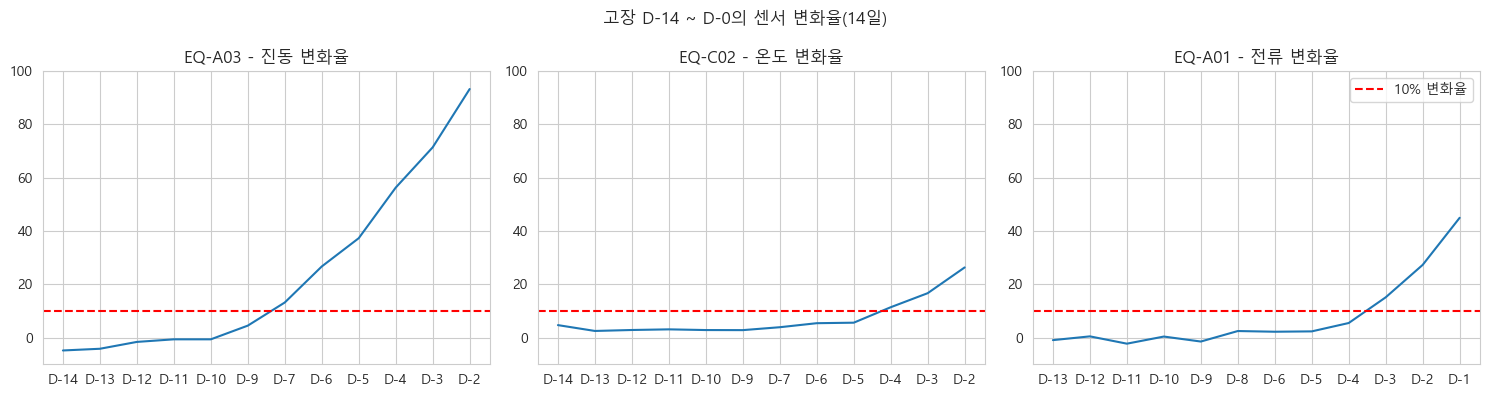

In [528]:
# 3. 3건의 고장 각각에 대해 **고장 D-14 ~ D-0의 센서 변화율**을 라인 차트로 시각화
#    - 1×3 서브플롯 (EQ-A03 진동, EQ-C02 온도, EQ-A01 전류)
#    - x축: D-14, D-13, ..., D-1, D-0
#    - y축: 변화율 (%)

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

a03_x = [f"D-{n}" for n in (pd.to_datetime('2024-04-15') - pd.to_datetime(eq_a03_fail_14.index)).days]
axs[0].plot(a03_x, eq_a03_fail_14['vib_변화율'])
axs[0].set_title('EQ-A03 - 진동 변화율')

c02_x = [f"D-{n}" for n in (pd.to_datetime('2024-05-20') - pd.to_datetime(eq_c02_fail_14.index)).days]
axs[1].plot(c02_x, eq_c02_fail_14['temp_변화율'])
axs[1].set_title('EQ-C02 - 온도 변화율')

a01_x = [f"D-{n}" for n in (pd.to_datetime('2024-03-10') - pd.to_datetime(eq_a01_fail_14.index)).days]
axs[2].plot(a01_x, eq_a01_fail_14['curr_변화율'])
axs[2].set_title('EQ-A01 - 전류 변화율')

# 4. 각 고장에서 **가장 먼저 10% 이상 변화**가 나타나는 시점(D-?)을 확인하세요
for ax in axs:
    ax.axhline(10, label='10% 변화율', color='red', linestyle='--')
    ax.set_ylim(-10, 100)

plt.suptitle('고장 D-14 ~ D-0의 센서 변화율(14일)')
plt.legend()

plt.tight_layout()
plt.show()

### 문제 3-2: 정비 이력과 센서 상관관계 (10점)

1. `maint` 테이블에서 CM(고장수리) 건만 필터링
2. 각 고장수리 발생일 **전 7일간**의 평균 센서값(온도, 진동)과  
   **평상시** 평균 센서값을 비교하는 표를 만드세요
3. 예방정비(PM) 전후 7일간의 센서값 변화도 비교하세요
   - PM 전 7일 평균 vs PM 후 7일 평균
   - **예방정비 효과**가 센서값으로 확인되는가?
4. **라인별 고장 건수**, **라인별 PM 건수**, **설비 나이**를 결합하여  
   PM을 잘 지킨 라인이 고장이 적은지 확인하세요

In [573]:
# 1. `maint` 테이블에서 CM(고장수리) 건만 필터링
maint_cm = maint[maint['maintenance_type'] == 'CM']
maint_cm

,maintenance_id,date,equipment_id,maintenance_type,description,cause,duration_hours,cost_won,parts_replaced,technician_id
4,MT-00005,2024-01-04,EQ-C03,CM,고장수리 - 모터과열,모터과열,46.0,1237000,NaN,TECH-04
13,MT-00014,2024-01-13,EQ-B04,CM,고장수리 - 유압누유,유압누유,42.0,1613000,볼트,TECH-06
21,MT-00022,2024-01-16,EQ-A04,CM,고장수리 - 센서고장,센서고장,15.0,1423000,필터,TECH-05
47,MT-00048,2024-02-14,EQ-A04,CM,고장수리 - 모터과열,모터과열,46.0,1057000,필터,TECH-05
67,MT-00068,2024-02-27,EQ-A02,CM,고장수리 - 냉각계통이상,냉각계통이상,10.0,418000,볼트,TECH-03
78,MT-00079,2024-03-06,EQ-A01,CM,고장수리 - 센서고장,센서고장,43.0,1132000,오일,TECH-08
97,MT-00098,2024-03-21,EQ-A01,CM,고장수리 - 기어손상,기어손상,25.0,256000,필터,TECH-01
113,MT-00114,2024-04-05,EQ-A03,CM,고장수리 - 전기접촉불량,전기접촉불량,12.0,1915000,필터,TECH-06
114,MT-00115,2024-04-05,EQ-B02,CM,고장수리 - 스핀들이상,스핀들이상,16.0,1026000,베어링,TECH-04
126,MT-00127,2024-04-15,EQ-A03,CM,고장수리 - 냉각계통이상,냉각계통이상,18.0,1400000,씰,TECH-08


In [ ]:
# 2. 각 고장수리 발생일 **전 7일간**의 평균 센서값(온도, 진동)과  
#    **평상시** 평균 센서값을 비교하는 표를 만드세요

def get_sensor_avg(row):
    mask7 = (sensor['equipment_id'] == row['equipment_id']) & \
            (sensor['timestamp'] >= row['date'] - pd.Timedelta(days=7)) & \
            (sensor['timestamp'] < row['date'])

    mask = (sensor['equipment_id'] == row['equipment_id']) & \
           (sensor['timestamp'] >= row['date'] - pd.Timedelta(days=30)) & \
           (sensor['timestamp'] < row['date'] - pd.Timedelta(days=7))
    
    sensor_mean7 = sensor.loc[mask7, ['temperature_c', 'vibration_mms']].mean()
    sensor_mean = sensor.loc[mask, ['temperature_c', 'vibration_mms']].mean()
    return pd.concat([sensor_mean7, sensor_mean]).values

maint_cm[['temp_mean7', 'vib_mean7', 'temp_mean', 'vib_mean']] = maint_cm.apply(get_sensor_avg, axis=1, result_type='expand')
maint_cm = maint_cm.dropna()

,maintenance_id,date,equipment_id,maintenance_type,description,cause,duration_hours,cost_won,parts_replaced,technician_id,temp_mean7,vib_mean7,temp_mean,vib_mean
13,MT-00014,2024-01-13,EQ-B04,CM,고장수리 - 유압누유,유압누유,42.0,1613000,볼트,TECH-06,36.702113,1.067887,36.873729,1.176102
21,MT-00022,2024-01-16,EQ-A04,CM,고장수리 - 센서고장,센서고장,15.0,1423000,필터,TECH-05,40.781690,1.819085,40.769620,1.809873
47,MT-00048,2024-02-14,EQ-A04,CM,고장수리 - 모터과열,모터과열,46.0,1057000,필터,TECH-05,40.562319,1.830145,40.951293,1.856573
67,MT-00068,2024-02-27,EQ-A02,CM,고장수리 - 냉각계통이상,냉각계통이상,10.0,418000,볼트,TECH-03,41.472059,2.403235,41.931757,2.314527
78,MT-00079,2024-03-06,EQ-A01,CM,고장수리 - 센서고장,센서고장,43.0,1132000,오일,TECH-08,43.190845,2.579507,42.793805,2.559912
97,MT-00098,2024-03-21,EQ-A01,CM,고장수리 - 기어손상,기어손상,25.0,256000,필터,TECH-01,41.552113,2.328099,42.989189,2.520405
113,MT-00114,2024-04-05,EQ-A03,CM,고장수리 - 전기접촉불량,전기접촉불량,12.0,1915000,필터,TECH-06,44.690278,3.058403,44.687555,3.090175
114,MT-00115,2024-04-05,EQ-B02,CM,고장수리 - 스핀들이상,스핀들이상,16.0,1026000,베어링,TECH-04,38.245070,1.323380,37.744255,1.331957
126,MT-00127,2024-04-15,EQ-A03,CM,고장수리 - 냉각계통이상,냉각계통이상,18.0,1400000,씰,TECH-08,46.215942,4.606812,44.815068,3.097237
158,MT-00159,2024-05-11,EQ-C02,CM,고장수리 - 냉각계통이상,냉각계통이상,33.0,1529000,벨트,TECH-04,42.923944,2.071972,41.317660,2.078489


In [ ]:
# 3. 예방정비(PM) 전후 7일간의 센서값 변화도 비교하세요
#    - PM 전 7일 평균 vs PM 후 7일 평균
#    - **예방정비 효과**가 센서값으로 확인되는가?


In [ ]:
# 4. **라인별 고장 건수**, **라인별 PM 건수**, **설비 나이**를 결합하여  
#    PM을 잘 지킨 라인이 고장이 적은지 확인하세요

---
## Part 4: 설비 건강도 스코어링 (20점)

개별 센서 분석을 넘어, 설비의 **종합적인 건강 상태**를 점수화합니다.  
이를 통해 어떤 설비를 우선 정비해야 하는지 의사결정할 수 있습니다.

> **현업 포인트**: 설비 건강도 = f(센서 상태, 가동시간, 정비이력, 알람빈도)

### 문제 4-1: 설비 건강도 지표 설계 (10점)

다음 5가지 지표로 설비 건강도를 계산하세요 (각 지표 0~100점 정규화):

| 지표 | 계산 방법 | 가중치 |
|------|----------|--------|
| 센서 이상 점수 | 최근 30일 이상치 비율 (낮을수록 좋음) | 30% |
| 진동 수준 점수 | 최근 30일 평균 진동 (낮을수록 좋음) | 25% |
| 정비 이행률 | PM 건수 / 예정 PM 건수 (높을수록 좋음) | 20% |
| 고장 빈도 점수 | CM 건수 (적을수록 좋음) | 15% |
| 알람 빈도 점수 | 알람 건수 (적을수록 좋음) | 10% |

1. 각 지표를 0~100으로 정규화하세요 (min-max 또는 순위 기반)
   - 100점 = 최상 상태, 0점 = 최악 상태
2. 가중 평균으로 **종합 건강도 점수**를 계산
3. 설비별 건강도를 표로 출력 (내림차순)
4. 건강도 점수별 등급 부여:
   - A등급(80+), B등급(60~80), C등급(40~60), D등급(40 미만)

In [ ]:
# 여기에 코드 작성


### 문제 4-2: 설비 건강도 대시보드 (10점)

**2행 2열 (4패널)** 대시보드를 만드세요. Figure 크기: (16, 12)

| 위치 | 차트 | 내용 |
|------|------|------|
| (1,1) | 수평 바 차트 | 설비별 건강도 점수 (등급별 색상) |
| (1,2) | 히트맵 | 설비 × 5개 지표 점수 매트릭스 |
| (2,1) | 라인 차트 | 고장 설비(EQ-A03) 진동 시계열 + 이동평균 + 고장일 |
| (2,2) | 산점도 | 설비 나이 vs 건강도 점수 (크기=누적가동시간) |

전체 제목: '설비 건강도 모니터링 대시보드 (2024년 6월 기준)'

In [ ]:
# 여기에 코드 작성


---
## Part 5: 예지보전 전략 제안 (15점)

### 문제 5-1: 종합 분석 및 전략 제안 (15점)

분석 결과를 바탕으로 아래 항목을 **마크다운 셀에** 작성하세요.

1. **현재 설비 상태 요약**: 건강도 등급별 설비 분포
2. **고장 전조 패턴**: 어떤 센서가, 몇 일 전부터 변화하는가?
3. **이상탐지 방법 비교**: 3-Sigma vs 이동평균 기반, 각각의 장단점
4. **예방정비 효과**: PM이 센서값과 고장빈도에 미치는 영향
5. **우선 조치 대상 설비**: 건강도 기준 하위 3대 설비와 조치 방안
6. **예지보전 시스템 제안**:
   - 어떤 센서를 우선 모니터링할 것인가?
   - 알람 임계값은 어떻게 설정할 것인가?
   - PM 주기를 어떻게 최적화할 것인가?

### 분석 결론 (여기에 작성)

1. **현재 설비 상태 요약**: 

2. **고장 전조 패턴**: 

3. **이상탐지 방법 비교**: 

4. **예방정비 효과**: 

5. **우선 조치 대상**: 

6. **예지보전 시스템 제안**: 


---
## 수고하셨습니다!

### 학습 체크리스트
- [ ] 시계열 센서 데이터 보간(interpolation) 처리
- [ ] 설비별 센서 기본 통계 비교
- [ ] 이동평균과 시계열 시각화
- [ ] 3-Sigma 이상탐지 구현 및 시각화
- [ ] 이동평균 기반 동적 이상탐지
- [ ] 고장 전조 패턴 (D-14 ~ D-0) 변화율 분석
- [ ] 정비 이력과 센서 데이터 연계 분석
- [ ] 설비 건강도 스코어링 설계 및 계산
- [ ] 4패널 대시보드 구성
- [ ] 데이터 기반 예지보전 전략 제안